In [1]:
import os
import sys
import re
import time
import matplotlib
import matplotlib.pyplot as plt
import random

parentPath = os.path.abspath("../..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)

import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = parentPath

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

SCENENN_DIR = "/external_datasets/SceneNet_RGBD"

Using TensorFlow backend.


In [2]:
# import SceneNet
from dataset import *

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
# Validation dataset
dataset_test = ObjectsDataset()
dataset_test.load_sceneNet(SCENENN_DIR, "validation")
dataset_test.prepare()

Loading validation data from 170
added 300 images for validation


## Detection

In [5]:
class InferenceConfig(ObjectsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

/external_datasets/SceneNet_RGBD/validation/0/170/photo/6475.jpg
image                    shape: (320, 320, 3)         min:    0.00000  max:  255.00000
depth                    shape: (320, 320)            min:    0.00000  max: 2351.00000
image_meta               shape: (10,)                 min:    0.00000  max:  320.00000
bbox                     shape: (3, 4)                min:    0.00000  max:  320.00000
mask                     shape: (320, 320, 3)         min:    0.00000  max:    1.00000


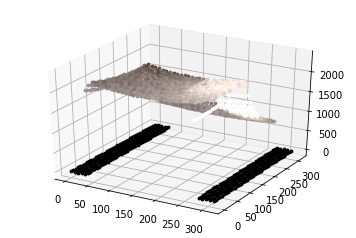

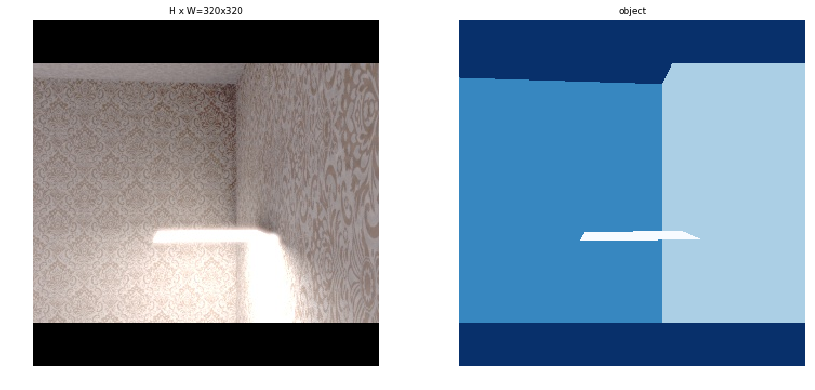

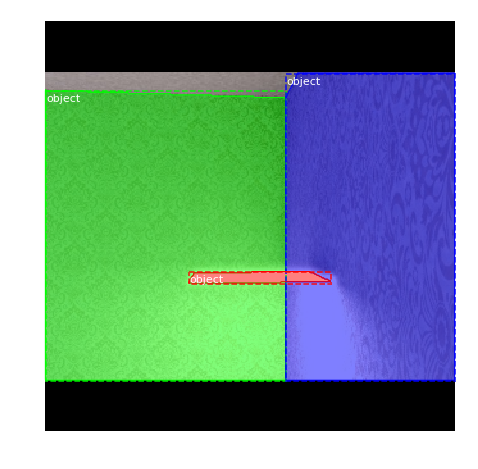

In [14]:
# Test on a random image
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, class_ids, bbox, mask=\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)
print(dataset_test.image_info[image_id]['path'])
image = original_image[:, :, 0:3]
depth = original_image[:, :, 3]
log("image", image)
log("depth", depth)
log("image_meta", image_meta)
log("bbox", bbox)
log("mask", mask)
if 1:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    skip = 8
    for x in range(image.shape[0]):
        if x % skip == 0:
            for y in range(image.shape[1]):
                if y % skip == 0:
#                     print(image[x, y] / 255.0)
                    ax.scatter(
                        x, y, depth[x, y],
                        c=image[x, y] / 255.0, s=8)
    plt.show()

visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names, limit=1)

visualize.display_instances(image, bbox, mask, class_ids, dataset_test.class_names, figsize=(8, 8))

In [7]:
# model_paths = model.find_all()
# for model_path in model_paths:
#     print("Loading weights from ", model_path[0])
#     for checkpoint in model_path[1]:
#         print("    " + checkpoint)
        # model.load_weights(checkpoint, by_name=True)
model.load_weights(model.find_last()[1], by_name=True)
start = time.clock()
r = model.detect([original_image])[0]
print(time.clock() - start)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                    dataset_test.class_names, r['scores'], ax=get_ax())

TypeError: expected str, bytes or os.PathLike object, not NoneType

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_test.image_ids, 20)
APs = []
for i, image_id in enumerate(image_ids):
    # Load image and ground truth data
    image_path = dataset_test.image_info[image_id]['path']
    try:
        image, image_meta, gt_class_id, gt_bbox, gt_mask  =\
            modellib.load_image_gt(dataset_test, inference_config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, r["rois"], r["class_ids"], r["scores"])
        APs.append(AP)
        print('{}: {}: {}'.format(i + 1, image_path, AP))
    except:
        print("Error processing image {}".format(image_path))

print("mAP: ", np.mean(APs))